# Piechart Figures
- The first figure shows the breakdown of each module's synaptic connection location on the oviIN neuron body. This gives us an idea of how the modularity sorts the pre-synaptic connectome
- The second figure shows where all the synapses in the pre-synaptic connectome are made, broken down by the module that the pre-synaptic neuron is sorted into at 0.0 resolution

This file is easily adjusted to any dataset in the v1.2.1.

Written by Rhessa Weber Langstaff

In [1]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Set 'pdf.fonttype' to 42 to keep the text editable after exporting to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['font.size'] = 14  # Default text size
plt.rcParams['axes.titlesize'] = 18  # Title size
plt.rcParams['figure.titlesize'] = 18  # Figure title size
plt.rcParams['axes.labelsize'] = 14  # X and Y label size
plt.rcParams['xtick.labelsize'] = 12  # X tick label size
plt.rcParams['ytick.labelsize'] = 12  # Y tick label size
plt.rcParams['legend.fontsize'] = 12  # Legend font size

In [2]:
pwd

'/Users/rweberla/Documents/GitHub/oviIN-inputs'

In [3]:
from neuprint import Client
from neuprint import fetch_synapse_connections, NeuronCriteria as NC, fetch_all_rois, fetch_primary_rois, fetch_adjacencies
from neuprint import fetch_roi_hierarchy, fetch_mean_synapses, SynapseCriteria as SC, fetch_simple_connections

auth_token_file = open("/Users/rweberla/flybrain-clustering-rhessa/flybrain.auth.txt", 'r') # need file containing the authentication token
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
    np_client.fetch_version()
except:
    np_client = None

Read in dataframe with super, L1, L2, L3, and L4. Created this file by following the output of the fetch_roi_hierarchy function. Super column is larger functional groups that we decided using Nomenclature paper (link). {{Please explain what the dfferent levels correspond to and which level(s) correspond to Primary ROIs in Neuprint.}}

In [4]:
roi_df = pd.read_excel('data/all_roi_df.xlsx')
roi_df

,Super,Super_split,L1,L2,L3,L4,Color,Color2
0,AL,AL(L),AL(L),AL(L),NaN,NaN,cadetblue,NaN
1,AL,NaN,NaN,AL-D(L),NaN,NaN,NaN,cadetblue
2,AL,NaN,NaN,AL-DA2(L),NaN,NaN,NaN,cadetblue
3,AL,NaN,NaN,AL-DA3(L),NaN,NaN,NaN,cadetblue
4,AL,NaN,NaN,AL-DA4m(L),NaN,NaN,NaN,cadetblue
...,...,...,...,...,...,...,...,...
225,VMNP,NaN,NaN,VES(L),NaN,NaN,NaN,firebrick
226,VMNP,NaN,NaN,VES(R),NaN,NaN,NaN,firebrick
227,AL,AL(L),mALT(L),mALT(L),NaN,NaN,cadetblue,NaN
228,AL,AL(R),mALT(R),mALT(R),NaN,NaN,cadetblue,NaN


In [5]:
# Adjust dataset here
direct = "modularity_runs/0.0/"
filename = "0-0_98765.txt"

ins_r = pd.read_csv(os.path.join(direct, filename), sep=" ", header=None, names=["id", "0.0"])
ins_r

,id,0.0
0,1003215282,1
1,1005952640,2
2,1006928515,3
3,1007260806,3
4,1008024276,4
...,...,...
1827,987117151,2
1828,987273073,6
1829,988567837,5
1830,988909130,5


In [6]:
# Fetch synaptic connections to the oviINr, can take around 30 seconds and sometimes times out
ids = ins_r["id"]
roi_info = fetch_synapse_connections(NC(bodyId=ids), NC(bodyId=423101189), batch_size=1000)
roi_info

  0%|          | 0/18782 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,796889169,423101189,SMP(R),SMP(R),23373,32251,13044,23358,32282,13050,0.990,0.469301
1,796889169,423101189,SMP(R),SMP(R),22244,27537,12483,22226,27529,12490,0.792,0.617000
2,800588608,423101189,SMP(R),SMP(R),22806,30682,12514,22806,30692,12487,0.968,0.673414
3,796755936,423101189,SMP(R),SMP(R),21571,35158,14105,21564,35145,14113,0.983,0.997687
4,796755936,423101189,SMP(R),SMP(R),23040,31908,12238,23021,31907,12242,0.964,0.993469
...,...,...,...,...,...,...,...,...,...,...,...,...
18777,821686394,423101189,IB,IB,24215,16528,21699,24219,16526,21672,0.718,0.985000
18778,821686394,423101189,VES(R),VES(R),23040,22648,28280,23057,22666,28260,0.910,0.534000
18779,821686394,423101189,VES(R),VES(R),23042,22640,28253,23057,22664,28259,0.785,0.465808
18780,821686394,423101189,VES(R),VES(R),23202,23713,28967,23218,23729,28967,0.862,0.898703


In [7]:
# alternatively, can load ovi_pre_syns.csv from the data folder
ovi_pre_syns = pd.read_csv("data/ovi_pre_syns.csv")

# grab oviINr synapse sites corresponding to traced, non-cropped neurons from sub-connectome
roi_info = ovi_pre_syns[ovi_pre_syns['bodyId_pre'].isin(ins_r['id'])]
roi_info

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,type_post
0,989228019,423101189,CRE(R),CRE(R),22857,34611,17485,22825,34624,17464,0.998,0.633171,FB5V,oviIN
1,988909130,423101189,CRE(R),CRE(R),19523,31096,21707,19509,31112,21693,0.969,0.528840,FB5V,oviIN
2,988567837,423101189,LAL(R),LAL(R),23100,27659,23824,23074,27659,23801,0.970,0.459446,FB4G,oviIN
4,987273073,423101189,CRE(R),CRE(R),19347,27826,15348,19351,27806,15376,0.943,0.595921,NaN,oviIN
5,987117151,423101189,LAL(R),LAL(R),19040,26341,22369,19033,26342,22353,0.937,0.960607,LAL010,oviIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21619,1006928515,423101189,IB,IB,22664,14840,19749,22651,14823,19757,0.994,0.865103,CL300,oviIN
21620,1005952640,423101189,IB,IB,21998,15625,18990,22007,15603,18991,0.996,0.929040,IB058,oviIN
21621,1005952640,423101189,IB,IB,22998,15275,23049,23014,15272,23060,0.835,0.780000,IB058,oviIN
21622,1005952640,423101189,IB,IB,23034,15380,23131,23048,15364,23146,0.986,0.905853,IB058,oviIN


# Synapses on oviIN breakdown

Here we pull all the connections made on the oviIN, specifically their super ROI grouping. These are grouped by coarse modularity cluster as well to determine whether modularity partitions correlate with locations of synaptic sites.

In [8]:
# Drop all unnecessary columns
roi_info_small = roi_info[['bodyId_pre', 'roi_post']]

# Collapse on roi_post and count the number of synapses in a new column called weight
roi_info_grouped = roi_info_small.groupby(['roi_post', 'bodyId_pre']).size().reset_index(name='weight')

# rename roi_post to roi
roi_info_grouped = roi_info_grouped.rename(columns = {'roi_post':'roi', 'bodyId_pre':'bodyId'})

In [9]:
# change weight to count
roi_info_grouped = roi_info_grouped.rename(columns = {'weight':'count'})

ins_r_e = pd.merge(ins_r, roi_info_grouped, left_on='id', right_on='bodyId', how='inner')

In [10]:
# get the roi dict for the super roi in ins_r_e
roi_ins_L2 = roi_df[roi_df['L2'].isin(ins_r_e['roi'].unique())]

roi_super_dict = roi_ins_L2.set_index('L2').to_dict()['Super']
roi_super_dict

{'ATL(R)': 'INP',
 'CRE(L)': 'INP',
 'CRE(R)': 'INP',
 'IB': 'INP',
 'LAL(R)': 'LX',
 'CAN(R)': 'PENP',
 'FLA(R)': 'PENP',
 'SIP(L)': 'SNP',
 'SMP(L)': 'SNP',
 'SIP(R)': 'SNP',
 'SMP(R)': 'SNP',
 'GOR(R)': 'VMNP',
 'SPS(R)': 'VMNP',
 'VES(R)': 'VMNP'}

In [11]:
# make a color dict for the super roi
color_dict = roi_ins_L2.set_index('Super').to_dict()['Color2']

In [12]:
# Parameters needed for plotting
clusters = ins_r_e["0.0"].unique()
super_title = 'OviINr Inputs Subconnectome Modules \nNeuropils of synaptic connections to oviINr'
label_threshold = 1
#color_dict = {'SNP': 'cornflowerblue', 'VMNP': 'firebrick', 'LX': 'blueviolet', 'INP': 'green'}
weight_threshold = 1
#plot_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.']

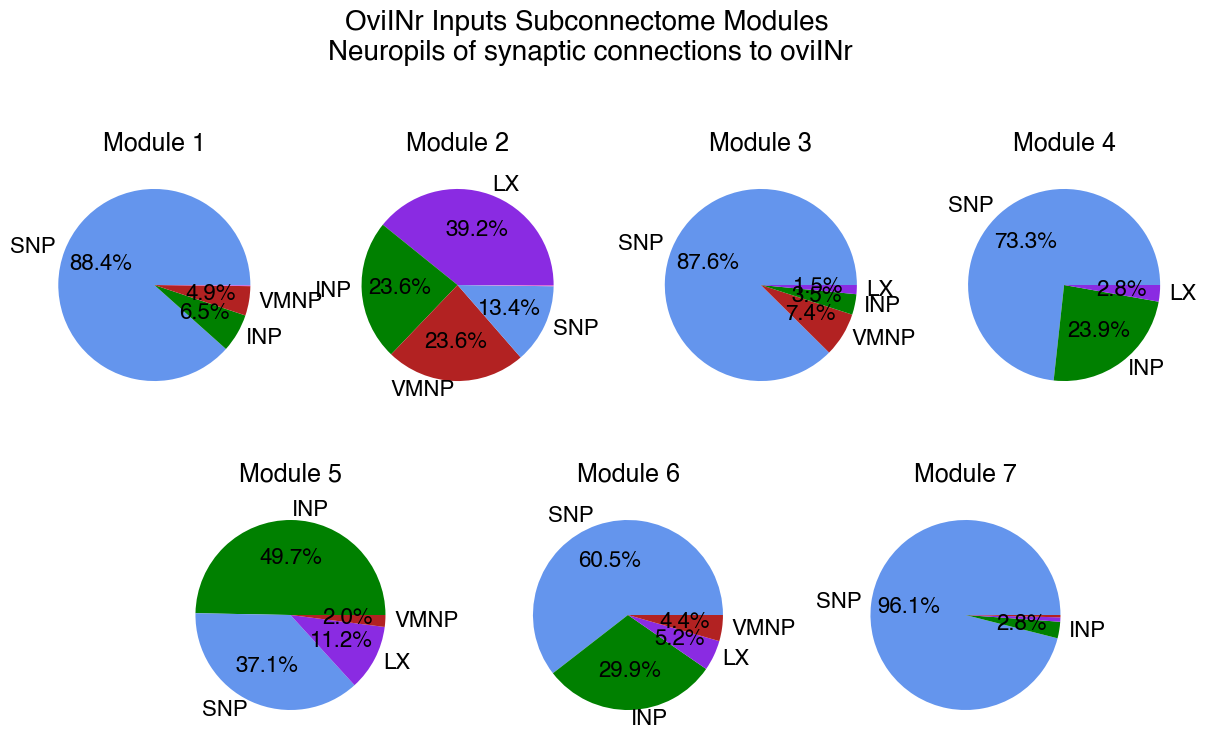

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
plt.suptitle(super_title, fontsize=20)
for i in clusters: 
        roi_grouped = ins_r_e[ins_r_e['0.0'] == i].groupby('roi', as_index=False).agg({'count': 'sum'})
        
        # Assign preferred roi
        roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
        roi_grouped = roi_grouped.drop(columns=['roi'])

        # Add up total weight for the super roi
        roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'count':'sum'})  
        # thresholding out weights equal to or less than 1 and sort
        roi_total = roi_grouped[roi_grouped['count'] > 1].sort_values(by='count', ascending=False)

        # Assign color
        roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
        # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
        data = roi_total[roi_total['count'] > weight_threshold].sort_values(by='count', ascending=False)
    
        # plot pie chart by value counts without none
        w, text, at = ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].pie(data['count'], labels = data['super'], colors = data['color'], autopct='%.1f%%',textprops={'fontsize': 16},radius=0.95, startangle=0)
        for t, x in enumerate(at):
            # Convert third part of x from string to float
            z = float(x.get_text().split()[0][:-1])
            if z <= label_threshold:
                    text[t].set_text('')
                    at[t].set_text('')
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title('Module ' + str(i), fontsize=18)
        #ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title(plot_labels[i-1], fontweight='bold', loc='left', fontsize=16)

# Adjust subplot dimensions if number of clusters is odd
if (len(clusters) % 2):
    fig.delaxes(ax[1, 3])
    # move bottom 3 axes to the middle
    ax[1, 0].set_position([0.05, 0.25, 0.5, 0.25])
    ax[1, 1].set_position([0.3, 0.25, 0.45, 0.25])
    ax[1, 2].set_position([0.55, 0.25, 0.4, 0.25])


Text(0, 0.5, 'Synapse Count')

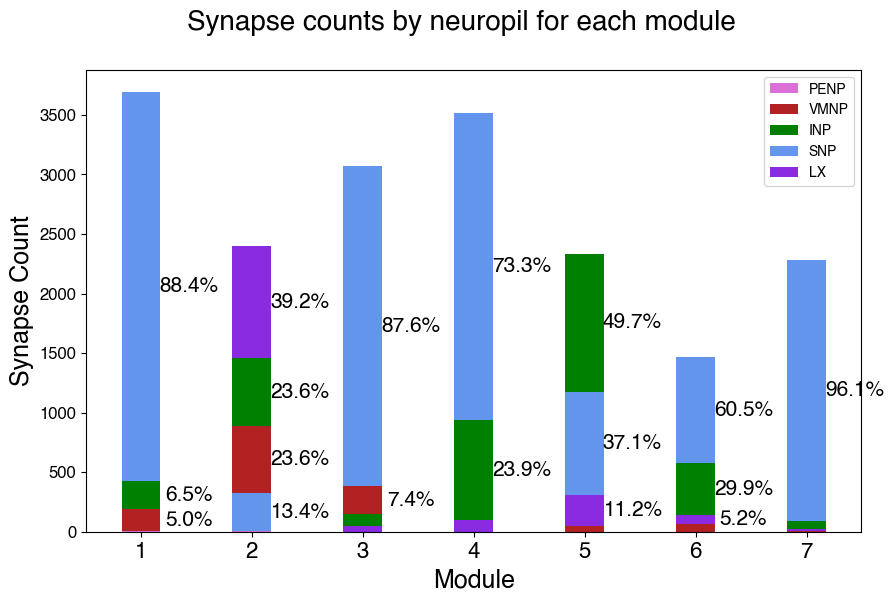

In [18]:
# Creating a stacked bar plot instead, each bar represents a module
fig, ax = plt.subplots(figsize=(10, 6))
# Set the figure title
plt.suptitle("Synapse counts by neuropil for each module", fontsize=20)
# Set the width of the bars
bar_width = 0.35

for x in clusters:
    # Get the data for the current cluster
    roi_grouped = ins_r_e[ins_r_e['0.0'] == x].groupby('roi', as_index=False).agg({'count': 'sum'})
    #print(roi_grouped)
    # Assign preferred roi
    roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
    roi_grouped = roi_grouped.drop(columns=['roi'])

    # Add up total weight for the super roi
    roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'count':'sum'})  
    # thresholding out weights equal to or less than 1 and sort
    roi_total = roi_grouped[roi_grouped['count'] > 3].sort_values(by='count', ascending=True)

    # Assign color
    roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
    # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
    data = roi_total[roi_total['count'] > weight_threshold].sort_values(by='count', ascending=True).reset_index(drop=True)
    #print(data)
    # plot a stacked bar 
    for i in data.index:
        if i == 0:
            ax.bar(x, data['count'][i], color=data['color'][i], label=data['super'][i], width=bar_width)
        else:
            # stack the bar ontop of the previous total plotted
            ax.bar(x, data['count'][i], color=data['color'][i], label=data['super'][i], bottom=data['count'][:i].sum(), width=bar_width)

   # Only display the unique labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=10)

   # label sections of the bar with the percentage
    for i in data.index:
        # Calculate the percentage
        percent = (data['count'][i] / data['count'].sum()) * 100
        if percent >4.5:
            # Add the percentage label to the bar
            ax.text(x+.43, data['count'][:i].sum() + data['count'][i] / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=15)

# Set the x-axis labels
ax.set_xlabel('Module', fontsize=18)
ax.set_xticks(clusters, labels=clusters, fontsize=16)
# Set the y-axis label
ax.set_ylabel('Synapse Count', fontsize=18)

In [15]:
fig.savefig("figures/roibreakdown_ovi_conns_pie.svg", format="svg")

# Portionality Plot

We want to see how the input connectome's synapses breakdown by cluster. This is done by finding the portion of connections an input neuron makes in each ROI compared to all the connections it makes. This is then adjusted into the Super ROI and added up as total portions.

In [16]:
# Pull presynpatic neurons outputs and input connections, takes about a minute
ids = ins_r["id"]
_, roi_info_p = fetch_adjacencies(NC(bodyId=ids), None)

_, roi_info_in_p = fetch_adjacencies(None, NC(bodyId=ids))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

The option to drop one or both oviINs from the inputs and outputs of the oviIN inputs is below. This did not make a significant difference in the results.

In [19]:
# option to remove both oviINs from the inputs to the presynaptic neurons
# body IDs of oviINs from Neuprint
oviINr_bodyID = 423101189
oviINl_bodyID = 485934965
# remove oviINr and oviINl from the presynaptic neurons
roi_info_p = roi_info_p[roi_info_p['bodyId_post'] != oviINr_bodyID]
roi_info_p = roi_info_p[roi_info_p['bodyId_post'] != oviINl_bodyID]
roi_info_in_p = roi_info_in_p[roi_info_in_p['bodyId_pre'] != oviINr_bodyID]
roi_info_in_p = roi_info_in_p[roi_info_in_p['bodyId_pre'] != oviINl_bodyID]

In [20]:
# Combine input and output roi info
roi_out = roi_info_p[['bodyId_pre', 'roi', 'weight']]
roi_in = roi_info_in_p[['bodyId_post', 'roi', 'weight']]

roi_out = roi_out.rename(columns = {'bodyId_pre':'bodyId'})
roi_in = roi_in.rename(columns = {'bodyId_post':'bodyId'})

roi_both = pd.concat([roi_out, roi_in], axis=0)
roi_both

,bodyId,roi,weight
0,263674097,SMP(R),1
1,263674097,SMP(R),23
2,263674097,SIP(R),5
3,263674097,LH(R),1
4,263674097,SIP(R),1
...,...,...,...
830503,484890037,SMP(L),1
830504,485628489,SMP(L),1
830505,574511458,SMP(L),1
830506,733182574,SMP(L),2


For each bodyID i want to get a fraction of how many synapses (weight) were made in an roi over the total number of synapses made by that bodyID and put that portionality in a new column.

In [21]:
# Drop all unnecessary columns
grouped_p = roi_both[['bodyId', 'roi', 'weight']].copy()
#grouped_p = roi_in[['bodyId', 'roi', 'weight']].copy() # for piechart of inputs only

# collapse on roi per bodyId and sum the weights
grouped_p = grouped_p.groupby(['bodyId', 'roi']).agg({'weight':'sum'}).reset_index()

# create a column that will contain the total number of synapses made by a bodyID
grouped_p['total'] = grouped_p.groupby('bodyId')['weight'].transform('sum')

# I will then create a new column that will contain the fraction of synapses made in an roi
# over the total number of synapses made by that bodyID
grouped_p['fraction'] = grouped_p['weight'] / grouped_p['total']

# I will drop the weight and total columns as they are no longer needed
grouped_p = grouped_p.drop(columns=['weight', 'total'])
grouped_p

,bodyId,roi,fraction
0,263674097,CRE(R),0.007114
1,263674097,LH(R),0.198171
2,263674097,NotPrimary,0.001016
3,263674097,PLP(R),0.004065
4,263674097,SCL(R),0.019309
...,...,...,...
14509,7112622044,SMP(R),0.195478
14510,7112622044,VES(L),0.025889
14511,7112622044,VES(R),0.007210
14512,7112622044,bL(L),0.000164


In this next dataframe we can see the cluster each neuron belongs in, the roi it falls into and the fraction of connections each neuron makes in that roi.

In [22]:
# Input modularity data for oviINr merged with the roi portionality data
in_r_p = pd.merge(ins_r, grouped_p, left_on='id', right_on='bodyId', how='inner')
in_r_p

,id,0.0,bodyId,roi,fraction
0,1003215282,1,1003215282,EPA(R),0.011146
1,1003215282,1,1003215282,GOR(R),0.125796
2,1003215282,1,1003215282,IB,0.213376
3,1003215282,1,1003215282,ICL(R),0.474522
4,1003215282,1,1003215282,SCL(R),0.127389
...,...,...,...,...,...
14509,989228019,5,989228019,CRE(R),0.301682
14510,989228019,5,989228019,FB,0.518392
14511,989228019,5,989228019,LAL(R),0.161106
14512,989228019,5,989228019,NotPrimary,0.006558


In [23]:
# create roi dictionaries for mapping
L2rois = roi_df.set_index('L2')['Super'].dropna().to_dict()
L3rois = roi_df.set_index('L3')['Super'].dropna().to_dict()

# combine the two dictionaries
roi_super_dict = L2rois
roi_super_dict.update(L3rois)

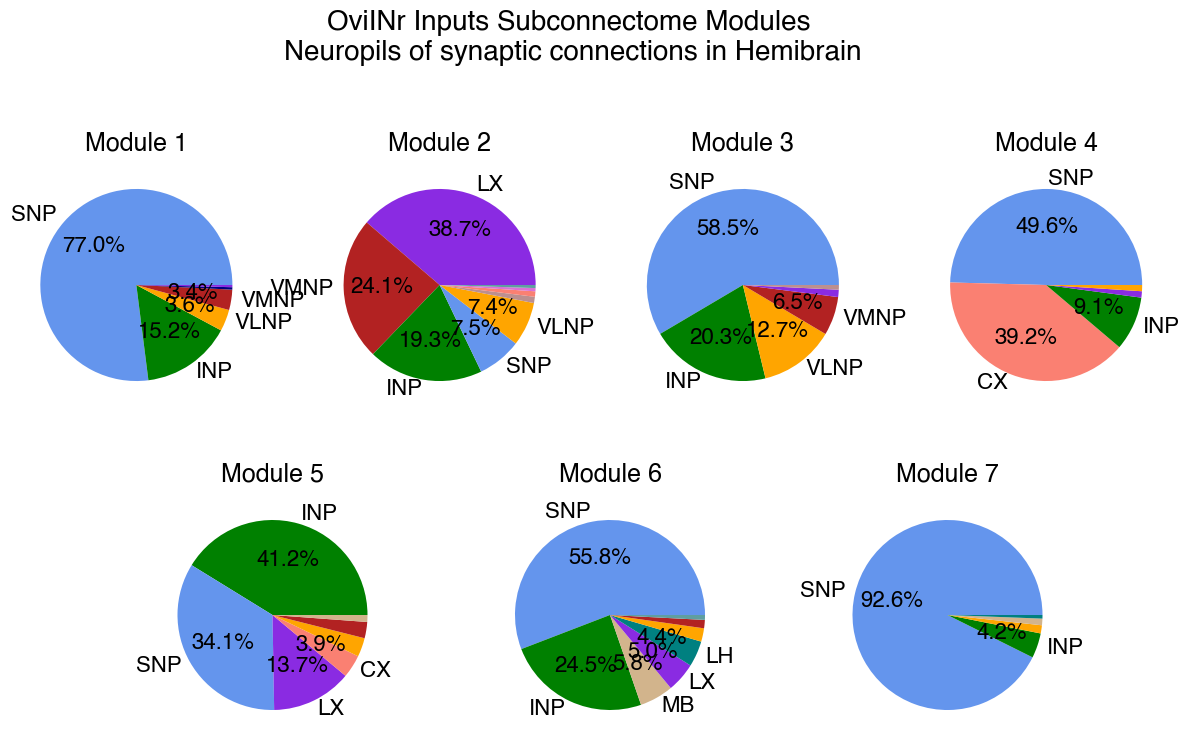

In [24]:
# Set color maps
color_dict = roi_df.set_index('Super')['Color'].dropna().to_dict()

# set label-threshold
label_threshold = 3.35
super_title = 'OviINr Inputs Subconnectome Modules \nNeuropils of synaptic connections in Hemibrain'

# Plot
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
#fig, ax = plt.subplots(3, 3, figsize=(15, 10))
plt.suptitle(super_title, fontsize=20)
for i in clusters: 
        # adds up the fraction of synapses in each roi for each module.
        # I'd prefer for it to do the mean of the fraction of synapses in each roi for each module but we don't have zero entries, so it would be skewed if we simply did mean instead of sum.
        # This is fine though. It's better than just adding up all the synapses everywhere. At least this scales the synapse counts by the total number of synapses made by the bodyId.
        roi_grouped = in_r_p[in_r_p['0.0'] == i].groupby('roi', as_index=False).agg({'fraction': 'sum'})

        # Assign preferred roi level (SUPER)
        roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
        roi_grouped = roi_grouped.drop(columns=['roi'])

        # Add up total weight for the super roi
        roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'fraction':'sum'})  
        roi_total = roi_grouped[roi_grouped['fraction'] > 1].sort_values(by='fraction', ascending=False)

        # Assign color
        roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
        # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
        data = roi_total[roi_total['fraction'] > weight_threshold].sort_values(by='fraction', ascending=False)
        #print(data)
        # plot pie chart by value counts without none
        w, text, at = ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].pie(data['fraction'], labels = data['super'], colors = data['color'], autopct='%.1f%%',textprops={'fontsize': 16},radius=0.95, startangle=0)
        for t, x in enumerate(at):
            # Convert third part of x from string to float
            z = float(x.get_text().split()[0][:-1])
            if z <= label_threshold:
                    text[t].set_text('')
                    at[t].set_text('')
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title('Module ' + str(i), fontsize=18)
        #ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title(plot_labels[i-1], fontweight='bold', loc='left', fontsize=16)

# Adjust subplot dimensions if less_clusters is True (for connectomes with odd number of clusters)
if (len(clusters) % 2):
    fig.delaxes(ax[1, 3])
    # move bottom 3 axes to the middle
    ax[1, 0].set_position([0.05, 0.25, 0.5, 0.25])
    ax[1, 1].set_position([0.3, 0.25, 0.45, 0.25])
    ax[1, 2].set_position([0.55, 0.25, 0.4, 0.25])

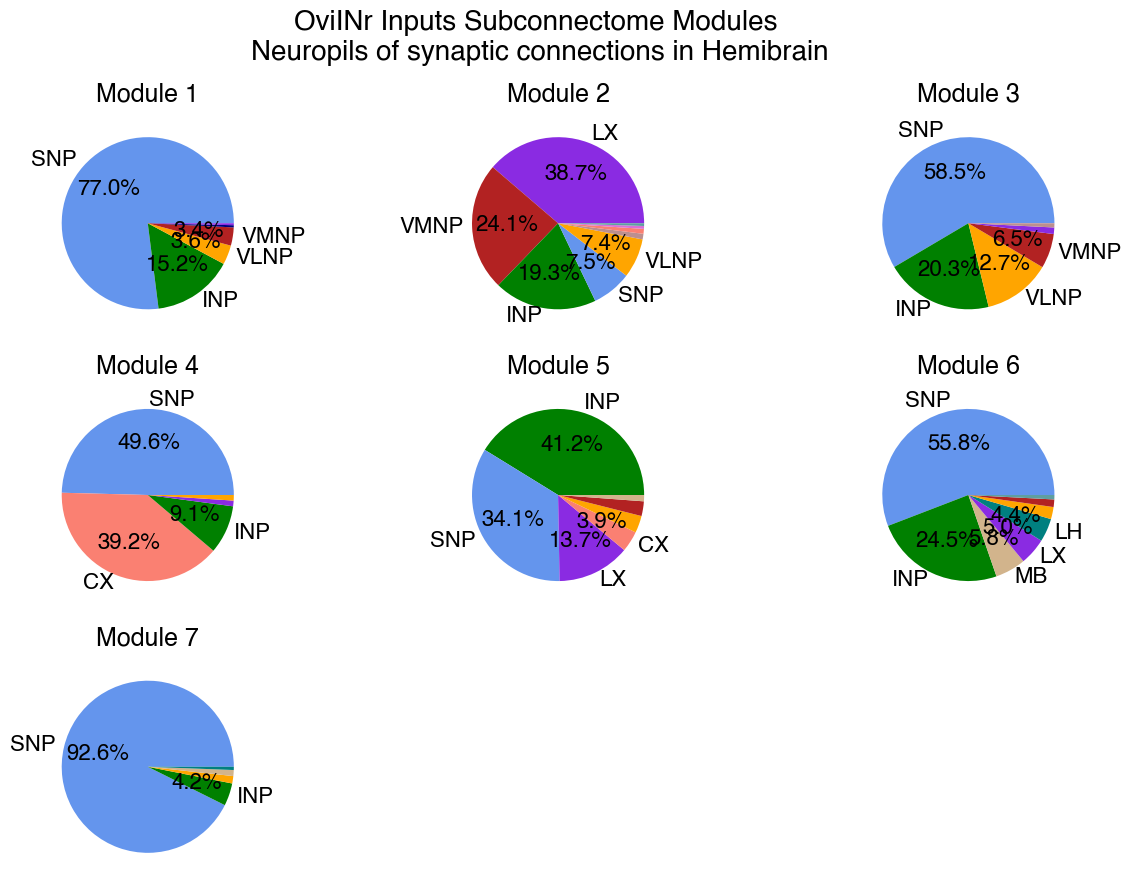

In [25]:
# Set color maps
color_dict = roi_df.set_index('Super')['Color'].dropna().to_dict()

# set label-threshold
label_threshold = 3.35
super_title = 'OviINr Inputs Subconnectome Modules \nNeuropils of synaptic connections in Hemibrain'

# Determine the number of rows and columns for subplots
num_clusters = len(clusters)
num_cols = 3
num_rows = (num_clusters + num_cols - 1) // num_cols

# Plot
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 10))
plt.suptitle(super_title, fontsize=20)
for i in clusters: 
        # adds up the fraction of synapses in each roi for each module.
        # I'd prefer for it to do the mean of the fraction of synapses in each roi for each module but we don't have zero entries, so it would be skewed if we simply did mean instead of sum.
        # This is fine though. It's better than just adding up all the synapses everywhere. At least this scales the synapse counts by the total number of synapses made by the bodyId.
        roi_grouped = in_r_p[in_r_p['0.0'] == i].groupby('roi', as_index=False).agg({'fraction': 'sum'})

        # Assign preferred roi level (SUPER)
        roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
        roi_grouped = roi_grouped.drop(columns=['roi'])

        # Add up total weight for the super roi
        roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'fraction':'sum'})  
        roi_total = roi_grouped[roi_grouped['fraction'] > 1].sort_values(by='fraction', ascending=False)

        # Assign color
        roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
        # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
        data = roi_total[roi_total['fraction'] > weight_threshold].sort_values(by='fraction', ascending=False)
        #print(data)
        # plot pie chart by value counts without none
        w, text, at = ax[int((i-1)/num_cols), (i-1)%num_cols].pie(data['fraction'], labels = data['super'], colors = data['color'], autopct='%.1f%%',textprops={'fontsize': 16},radius=0.95, startangle=0)
        for t, x in enumerate(at):
            # Convert third part of x from string to float
            z = float(x.get_text().split()[0][:-1])
            if z <= label_threshold:
                    text[t].set_text('')
                    at[t].set_text('')
        ax[int((i-1)/num_cols), (i-1)%num_cols].set_title('Module ' + str(i), fontsize=18)
        #ax[int((i-1)/num_cols), (i-1)%num_cols].set_title(plot_labels[i-1], fontweight='bold', loc='left', fontsize=16)

# Adjust subplot dimensions if the number of clusters is not a multiple of num_cols
if (num_clusters % num_cols):
    for j in range(num_clusters, num_rows * num_cols):
        fig.delaxes(ax[int(j/num_cols), j % num_cols])

# move bottom 3 axes to the middle if num_clusters is not divisible by num_cols
    #ax[num_rows-1, 0].set_position([0.3, 0.05, 0.25, 0.25])
    #ax[num_rows-1, 1].set_position([0.3, 0.25, 0.25, 0.25])
    #ax[num_rows-1, 2].set_position([0.55, 0.25, 0.25, 0.25])

In [26]:
fig.savefig("figures/portionality_HB_conns_pie.svg", format="svg")

In [27]:
in_r_p

,id,0.0,bodyId,roi,fraction
0,1003215282,1,1003215282,EPA(R),0.011146
1,1003215282,1,1003215282,GOR(R),0.125796
2,1003215282,1,1003215282,IB,0.213376
3,1003215282,1,1003215282,ICL(R),0.474522
4,1003215282,1,1003215282,SCL(R),0.127389
...,...,...,...,...,...
14509,989228019,5,989228019,CRE(R),0.301682
14510,989228019,5,989228019,FB,0.518392
14511,989228019,5,989228019,LAL(R),0.161106
14512,989228019,5,989228019,NotPrimary,0.006558


Text(0, 0.5, 'Fraction of Synapses')

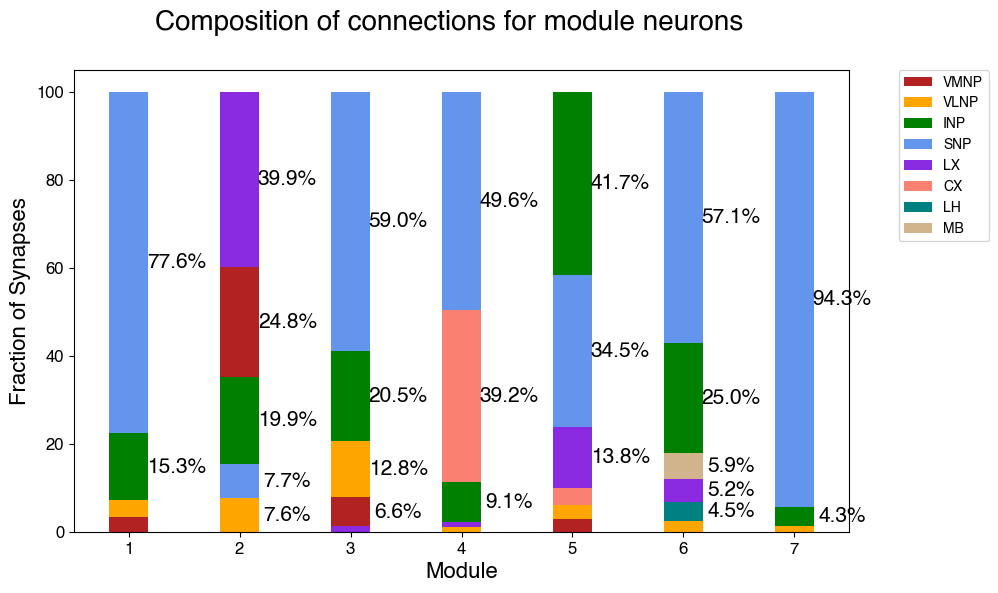

In [28]:
# create stacked bar plot instead, each bar represents a module
fig, ax = plt.subplots(figsize=(10, 6))
# Set the figure title
plt.suptitle("Composition of connections for module neurons", fontsize=20)
# Set the width of the bars
bar_width = 0.35

for x in clusters:
    # Get the data for the current cluster
    roi_grouped = in_r_p[in_r_p['0.0'] == x].groupby('roi', as_index=False).agg({'fraction': 'sum'})
    #print(roi_grouped)
    # Assign preferred roi
    roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
    roi_grouped = roi_grouped.drop(columns=['roi'])

    # Add up total weight for the super roi
    roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'fraction':'sum'})  
    # thresholding out weights equal to or less than 1 and sort
    roi_total = roi_grouped[roi_grouped['fraction'] > 3].sort_values(by='fraction', ascending=True)
    #print(roi_total)
    # Assign color
    roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
    # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
    data = roi_total[roi_total['fraction'] > weight_threshold].sort_values(by='fraction', ascending=True).reset_index(drop=True)
    #print(data)
    # plot a stacked bar 
    for i in data.index:
        if i == 0:
            percent = ((data['fraction'][i] / data['fraction'].sum()) * 100)
            #print(percent)
            ax.bar(x, percent, color=data['color'][i], label=data['super'][i], width=bar_width)
        else:
            # stack the bar ontop of the previous total plotted
            percent = (data['fraction'][i] / data['fraction'].sum()) * 100
            #print(percent)
            ax.bar(x, percent, color=data['color'][i], label=data['super'][i], bottom=(data['fraction'][:i].sum() / data['fraction'].sum()) * 100, width=bar_width)

   # Only display the unique labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=10, bbox_to_anchor=(1.18, 1), borderaxespad=0.)

   # label sections of the bar with the percentage
    for i in data.index:
        # Calculate the percentage
        percent = (data['fraction'][i] / data['fraction'].sum()) * 100
        if percent > 4:
            # Add the percentage label to the bar
            ax.text(x+.43, (percent / 2) + (data['fraction'][:i].sum() / data['fraction'].sum()) * 100, f'{percent:.1f}%', ha='center', va='center', fontsize=15)

ax.set_xlabel('Module', fontsize=16)
ax.set_ylabel('Fraction of Synapses', fontsize=16)

This is showing the portion of connections an input neuron makes in each ROI compared to all the connections it makes. \
The roi are then adjusted into the Super ROI and added up as total portions.


This makes the numbers a little weird. For the first module for example, each super group adds up the proportions a neuron makes in that super group which means it can be more than 100. 

However in the piecharts they calculated the percentage of each super group out of all the added up proportions. So plotting every bar out of 100 actually describes the same thing.